---
title: 10 - Re-running preprocessing
author: Martin Proks
date: 04-08-2023
---

This notebook is to address the reviewer's comments in regards to missing `Sox2` expression in the scRNAseq.

In [1]:
%matplotlib inline

import glob
import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt


from matplotlib.pyplot import rc_context

In [2]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings


warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

## 0. Original analysis

In [ ]:
adata_orig = sc.read("../data/processed/01_dataset_MLA.h5ad")
adata_orig.obs.seurat_clusters = adata_orig.obs.seurat_clusters.astype('category')

In [ ]:
sc.pl.umap(adata_orig, color=['Stage', 'seurat_clusters', 'Phase'], ncols=3, frameon=False)

## 1. Original Sox2 expression (bowtie2)

In [ ]:
original = sc.concat([
    sc.read_text(amp).T 
    for amp in glob.glob("../data/assays/SCR_20221006/processed/marsseq_16082023/output/umi.tab/*.txt")
])

In [ ]:
sc.pp.calculate_qc_metrics(original, inplace=True)

In [ ]:
original[:, 'Sox2'].var

## 2. Re-aligned (StarSolo)

In [ ]:
realigned = sc.read_10x_mtx("../data/assays/SCR_20221006/processed/marsseq/SB2/velocity/SB2.Solo.out/Gene/raw/")

In [ ]:
sc.pp.calculate_qc_metrics(realigned, inplace=True)

In [ ]:
realigned[:, 'Sox2'].var

## 3. Re-aligned with eGFP (StarSolo)

It could be since MARSseq is a 3' sequencing, that most of the sequence is eGFP tag and not the SOX2 sequence itself.

To solve this issue, we introduce eGFP sequence to the reference and compare the SOX2 vs SOX2_eGFP alignemnt. If it's
a sequencing issue we should see "recovered" counts from eGFP pseudogene.

In [ ]:
realigned_eGFP = sc.read_10x_mtx("../data/assays/SCR_20221006/processed/marsseq_eGFP/SB2/velocity/SB2.Solo.out/Gene/raw/")

In [ ]:
sc.pp.calculate_qc_metrics(realigned_eGFP, inplace=True)

In [ ]:
realigned_eGFP[:, 'Sox2'].var

In [ ]:
sc.pp.normalize_total(realigned_eGFP)
sc.pp.log1p(realigned_eGFP)

In [ ]:
df = realigned_eGFP[:, ['Sox2', 'eGFP_Sox2_gene']].to_df()

fig, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=[8, 3], constrained_layout=True)
_ = ax[0].hist(df['Sox2'], label='Sox2')
_ = ax[1].hist(df['eGFP_Sox2_gene'], label='Sox2 (eGFP)', color='orange')

_ = ax[0].legend()
_ = ax[1].legend()

_ = fig.supylabel('Counts')
_ = fig.supxlabel('Normalized & log-transformed gene expression')

We can see that the eGFP couldn't be detected, however the `Sox2` expression has been recovered with `StarSolo` as already shown in Section 2.

## 4. Downstream re-analysis (eGFP)

In [3]:
# original
# adata = sc.read_10x_mtx("../data/assays/SCR_20221006/processed/marsseq_eGFP/SB2/velocity/SB2.Solo.out/Gene/raw/")
adata = sc.read_10x_mtx("../data/assays/SCR_20221006/processed/marsseq/SB2/velocity/SB2.Solo.out/Gene/raw/")

meta = pd.read_csv("../data/processed/00_metadata.csv", index_col=1)
meta['celltag'] = meta[['Pool_barcode', 'Cell_barcode']].agg(''.join, axis=1)
meta = meta.reset_index().set_index('celltag')
meta = meta[[
        'Well_ID', 'Well_coordinates', 'plate_ID',
        'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode',
        'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup',
        'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean']]

common_cells = adata.obs_names.intersection(meta.index)
adata = adata[common_cells].copy()
adata.obs = meta.loc[common_cells].copy()

/tmp/ipykernel_2982839/2892087162.py:5: DtypeWarning: Columns (22,32,70,71,72,79,90,99,113,119,134,143,152,153,162,165,166,193,194,201,204,213,233,234,245,253,256,264,268,275,276,283,303,304,315,317,318,398,416,417,420,477,479,552,634,642,643,646,666,683,731,866,877,1041,1043,1062,1093,1094,1132,1134,1184,1186,1192,1254,1286,1295) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv("../data/processed/00_metadata.csv", index_col=1)


In [4]:
adata

AnnData object with n_obs × n_vars = 1536 × 55359
    obs: 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean'
    var: 'gene_ids', 'feature_types'

In [5]:
adata.obs.plate_ID = adata.obs.plate_ID.astype('category')

# Remove Zero
adata = adata[adata.obs.Stage != 'Zero'].copy()
adata = adata[adata.obs.Stage != 'nEnd_double'].copy()
adata = adata[adata.obs.Stage != 'nEnd_GFP'].copy()
adata = adata[adata.obs.Stage != 'nEnd_cherry'].copy()

# Actually 2C, keep it
# cells_2C = ['AGTCTCGTGAG', 'CATGCATGGAT', 'CTACCAATGCG', 'CTACTCGATAC', 'TGATGAGCTAG', 'TGATTACGAGG']

# Remove ERCC cells
adata = adata[:, ~adata.var_names.str.startswith('ERCC-')]

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
adata.var['ercc'] = adata.var_names.str.startswith('ERCC-')
adata.var['ribo'] = adata.var_names.str.startswith(('Rpl', 'Rps'))

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ercc', 'ribo'], percent_top=None, log1p=False, inplace=True)

/tmp/ipykernel_2982839/3810762444.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('mt-')


<AxesSubplot:ylabel='pct_counts_mt'>

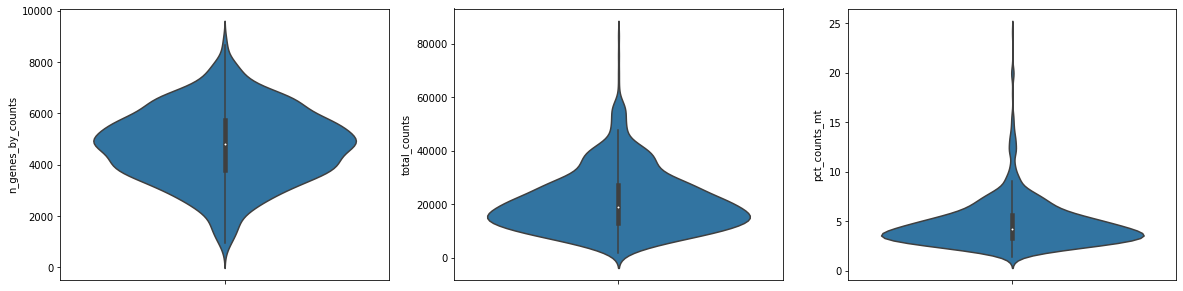

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.violinplot(y=adata.obs['n_genes_by_counts'], orient='v', ax=ax[0])
sns.violinplot(y=adata.obs['total_counts'], orient='v', ax=ax[1])
sns.violinplot(y=adata.obs['pct_counts_mt'], orient='v', ax=ax[2])

<AxesSubplot:xlabel='total_counts', ylabel='n_genes_by_counts'>

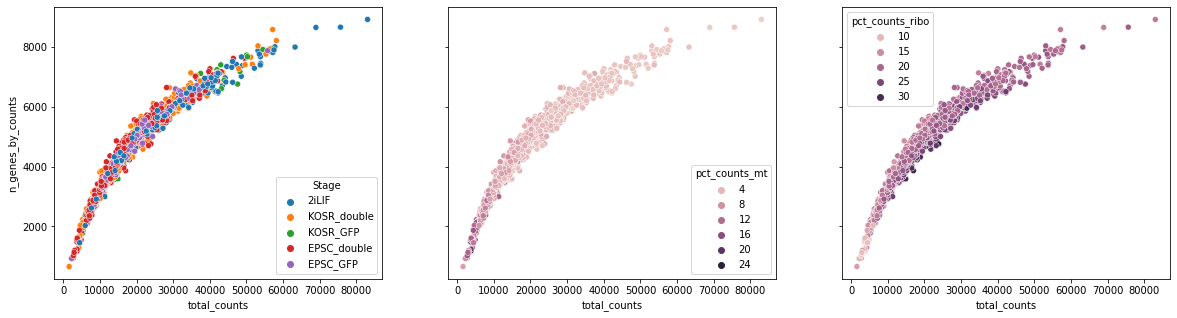

In [8]:
fig, ax = plt.subplots(1,3, figsize=(20, 5), sharey=True)
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[0], data=adata.obs, hue='Stage')
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[1], hue='pct_counts_mt', data=adata.obs)
sns.scatterplot(x='total_counts', y='n_genes_by_counts', ax=ax[2], hue='pct_counts_ribo', data=adata.obs)

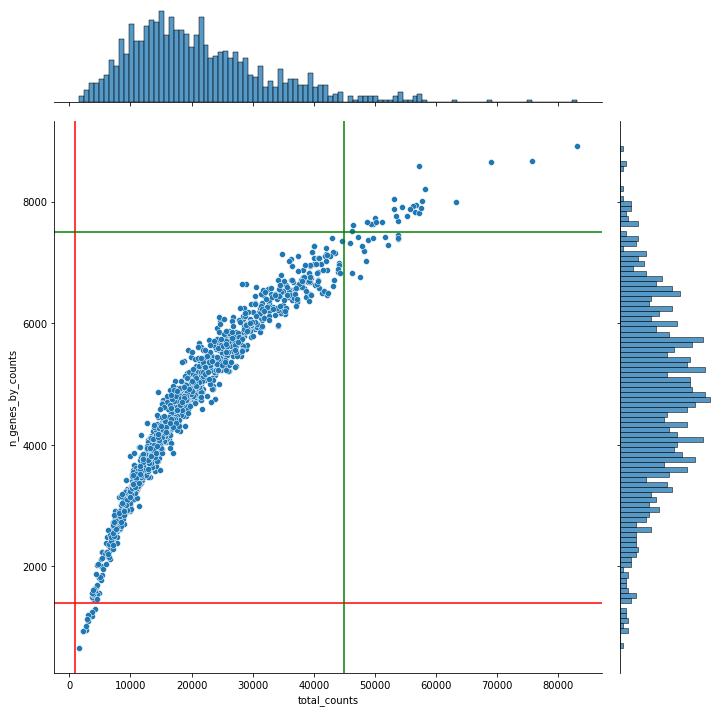

In [9]:
min_cells, max_cells = 1000, 45e3
min_genes, max_genes = 1400, 7_500

p = sns.jointplot(x='total_counts', y='n_genes_by_counts', data=adata.obs, marginal_kws=dict(bins=100), height=10)
# min
p.ax_joint.axvline(x=min_cells, color='red')
p.ax_joint.axhline(y=min_genes, color='red')

# max
p.ax_joint.axvline(x=max_cells, color='green')
p.ax_joint.axhline(y=max_genes, color='green')

In [10]:
print(f'Before filtering: {adata.shape}')

sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_cells(adata, min_counts=min_cells)
sc.pp.filter_cells(adata, max_counts=max_cells)
sc.pp.filter_cells(adata, max_genes=max_genes)

# adata = adata[adata.obs.pct_counts_mt < 10].copy()

sc.pp.filter_genes(adata, min_cells=3)
print(f'After filtering: {adata.shape}')

Before filtering: (1192, 55359)
After filtering: (1139, 21590)


<AxesSubplot:ylabel='pct_counts_ribo'>

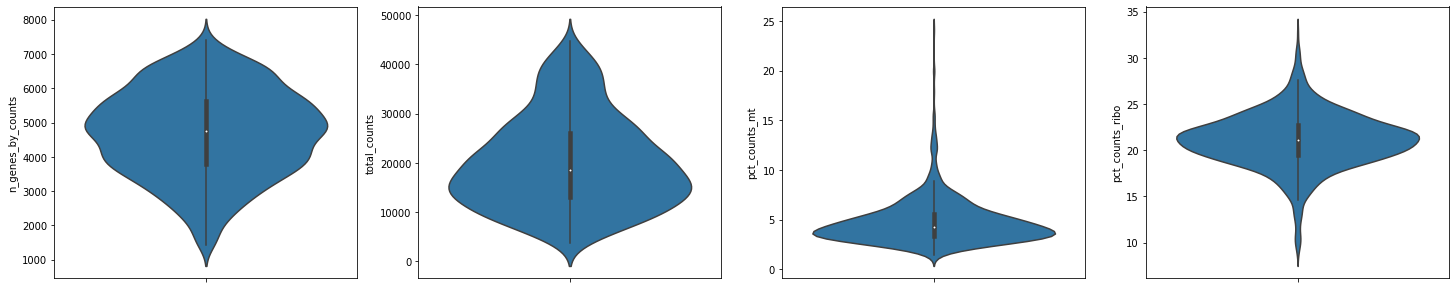

In [11]:
fig, ax = plt.subplots(1,4, figsize=(25, 5))
sns.violinplot(y=adata.obs['n_genes_by_counts'], orient='v', ax=ax[0])
sns.violinplot(y=adata.obs['total_counts'], orient='v', ax=ax[1])
sns.violinplot(y=adata.obs['pct_counts_mt'], orient='v', ax=ax[2])
sns.violinplot(y=adata.obs['pct_counts_ribo'], orient='v', ax=ax[3])

In [12]:
adata.layers['counts'] = adata.X.copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

/projects/dan1/people/fdb589/envs/scvi-0.17.1/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/projects/dan1/people/fdb589/envs/scvi-0.17.1/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/projects/dan1/people/fdb589/envs/scvi-0.17.1/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/projects/dan1/people/fdb589/envs/scvi-0.17.1/lib/python3.8/site-packa

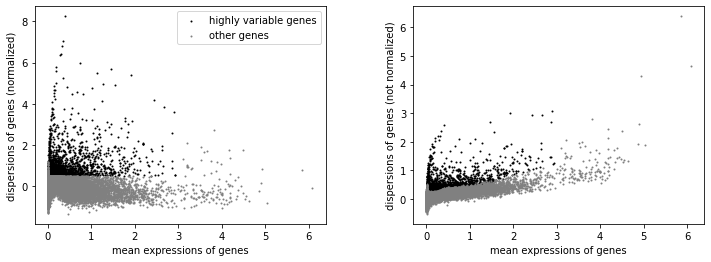

In [13]:
sc.pp.highly_variable_genes(adata, flavor="seurat", batch_key="Amp_batch_ID")

# this works
# sc.pp.highly_variable_genes(adata, flavor="seurat", batch_key="plate_ID")

# sc.pp.highly_variable_genes(adata, flavor="seurat")
sc.pl.highly_variable_genes(adata)

In [14]:
adata[:, adata.var.highly_variable]

View of AnnData object with n_obs × n_vars = 1139 × 2262
    obs: 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mt', 'ercc', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [15]:
sc.pp.scale(adata)

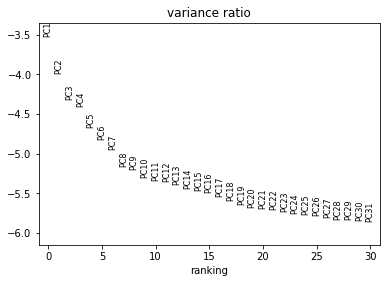

In [16]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

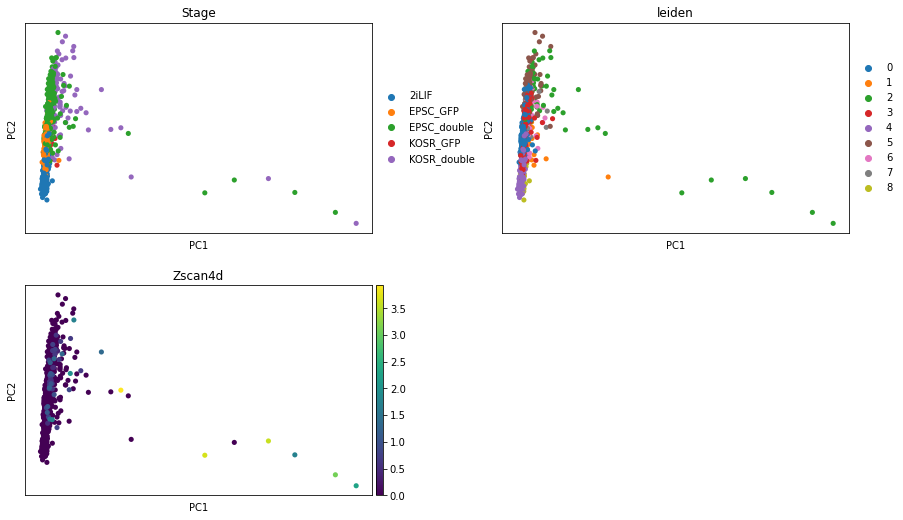

In [18]:
# Verify 2C cells
sc.pl.pca(adata, color=["Stage", "leiden", 'Zscan4d'], ncols=2, wspace=0.25)

In [19]:
import urllib.request, json 

cc_url = "https://github.com/brickmanlab/project-template/raw/master/%7B%7B%20cookiecutter.project_name%20%7D%7D/data/external/mouse_cell_cycle_genes.json"
with urllib.request.urlopen(cc_url) as url:
    cc = json.load(url)

sc.tl.score_genes_cell_cycle(adata, s_genes=cc['s'], g2m_genes=cc['g2m'], use_raw=False)

/projects/dan1/people/fdb589/envs/scvi-0.17.1/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/projects/dan1/people/fdb589/envs/scvi-0.17.1/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/tmp/ipykernel_2982839/2422794942.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cc_composition /= cc_composition.sum(axis=1)[:, np.newaxis]


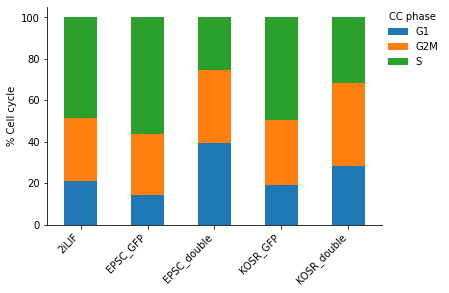

In [20]:
cc_composition = adata.obs.groupby(['Stage', 'phase']).apply(len).unstack().fillna(0)
cc_composition /= cc_composition.sum(axis=1)[:, np.newaxis]
cc_composition *= 100

cc_composition.plot(kind='bar', stacked=True)
plt.gca().legend(title='CC phase', bbox_to_anchor=(0.99, 1.02), loc='upper left', frameon=False)
plt.gca().spines[['right', 'top']].set_visible(False)
_ = plt.xticks(rotation=45, ha='right')
_ = plt.ylabel('% Cell cycle')
_ = plt.xlabel('')

In [21]:
adata

AnnData object with n_obs × n_vars = 1139 × 21590
    obs: 'Well_ID', 'Well_coordinates', 'plate_ID', 'Subject_ID', 'Amp_batch_ID', 'Cell_barcode', 'Pool_barcode', 'Batch', 'Condition', 'SampleName', 'Stage', 'Source', 'SubGroup', 'Group', 'Clone', 'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'leiden', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'mt', 'ercc', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'Stage_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'conne

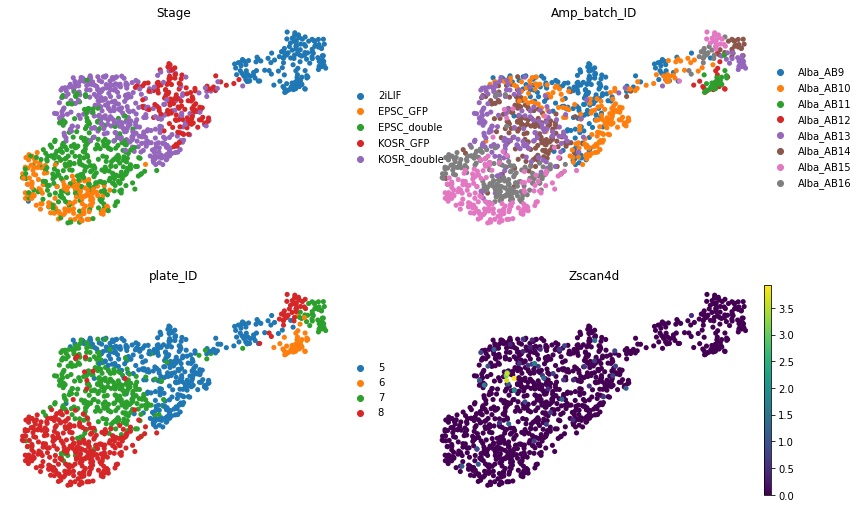

In [22]:
sc.pl.umap(adata, color=['Stage', 'Amp_batch_ID', 'plate_ID', 'Zscan4d'], ncols=2, frameon=False)

In [23]:
sc.tl.leiden(adata, resolution=0.4)

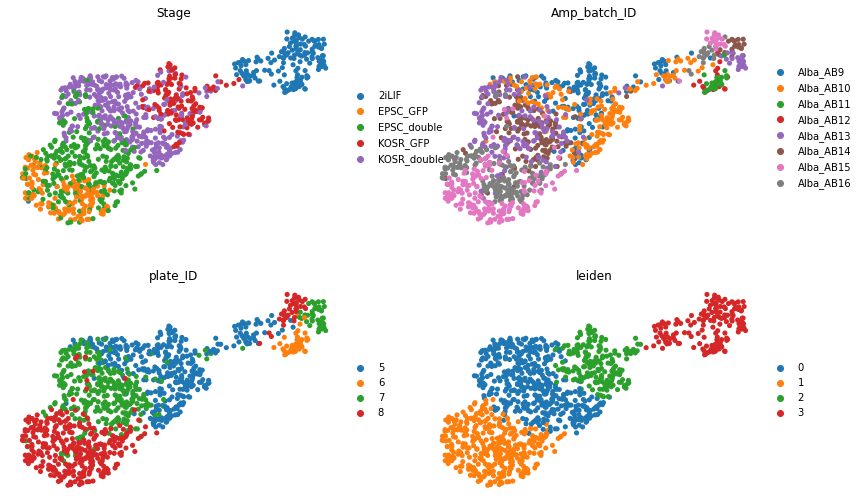

In [24]:
sc.pl.umap(adata, color=['Stage', 'Amp_batch_ID', 'plate_ID', 'leiden'], ncols=2, frameon=False)

### Find co-expressing genes

We define co-expression where Sox2 ang Gata6 have their $expr > 1.5$

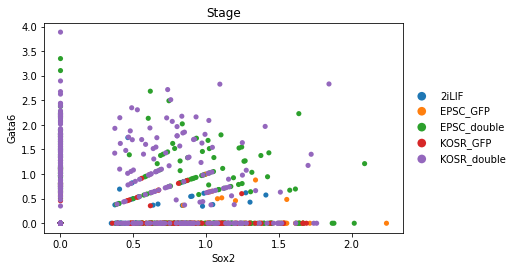

In [25]:
sc.pl.scatter(adata, x='Sox2', y='Gata6', color='Stage', use_raw=True)

In [26]:
df = pd.DataFrame(
    adata.raw[:, ['Sox2', 'Gata6']].X.A,
    index=adata.obs_names,
    columns=['Sox2', 'Gata6']
)

adata.obs['S2G6+'] = df.sum(axis=1) > 1.5
adata.obs['S2G6+'] = adata.obs['S2G6+'].astype('category')
adata.obs['S2G6+'] = adata.obs['S2G6+'].cat.rename_categories(['None', 'Co-expressed'])

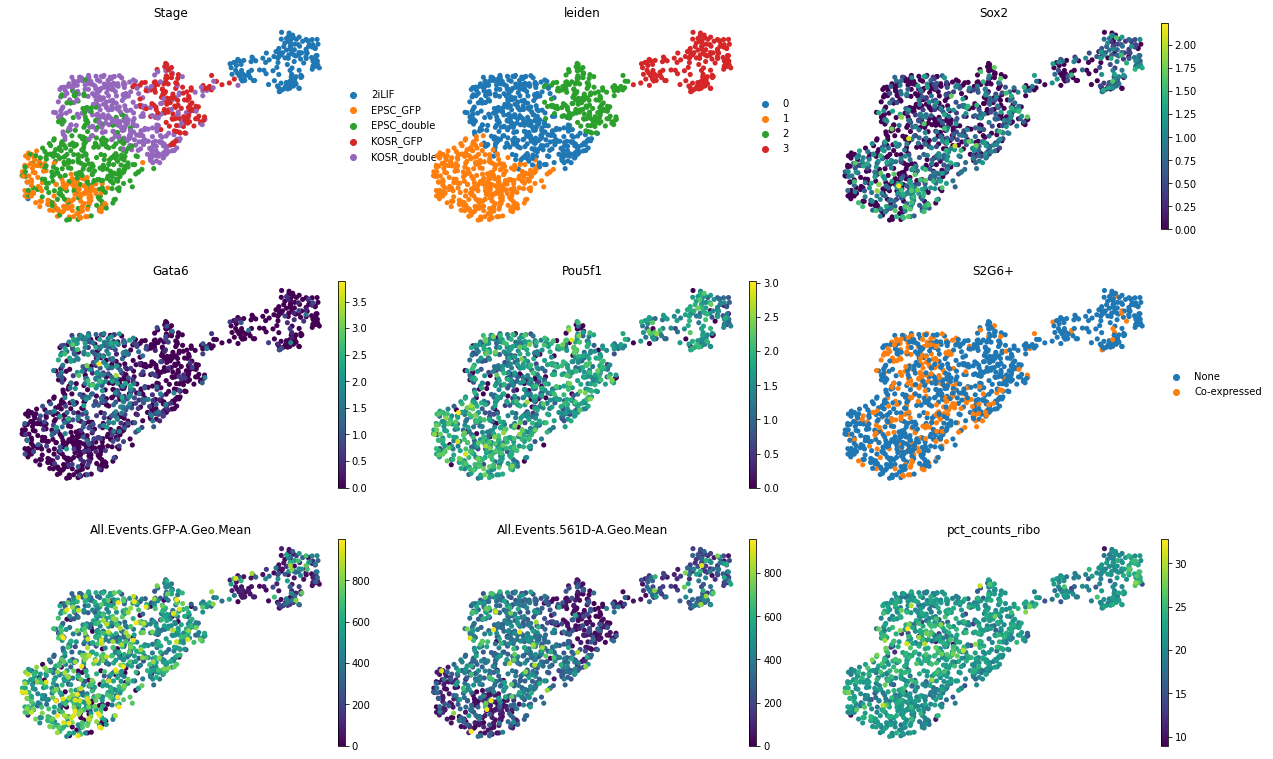

In [27]:
sc.pl.umap(adata, color=['Stage', 'leiden', 'Sox2', 'Gata6', 'Pou5f1', 'S2G6+',
                         'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean', 'pct_counts_ribo'], ncols=3, frameon=False)

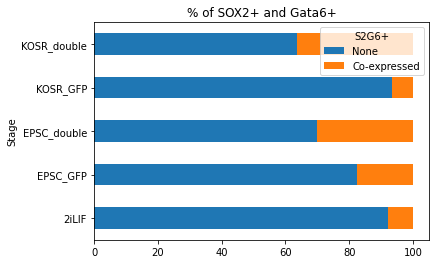

In [28]:
df = adata.obs.groupby(['Stage', 'S2G6+']).apply(len).unstack()
df = df / df.sum(axis=1).values[:, np.newaxis]
df *= 100

_ = df.plot.barh(title='% of SOX2+ and Gata6+', stacked=True)

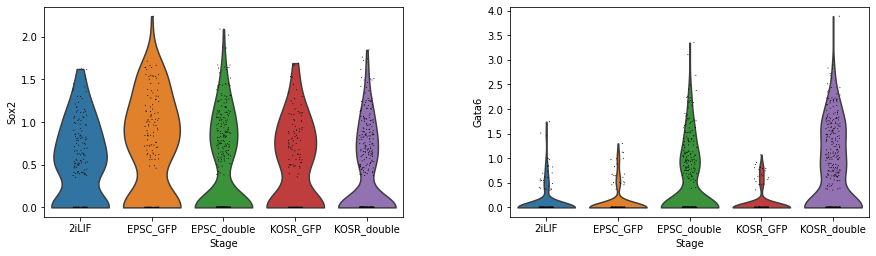

In [29]:
sc.pl.violin(adata, ['Sox2', 'Gata6'], groupby='Stage')

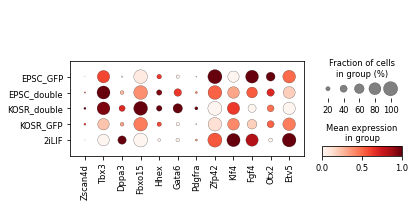

In [30]:
sc.pl.dotplot(adata,
              ['Zscan4d', 'Tbx3', 'Dppa3', 'Fbxo15', 'Hhex', 'Gata6', 'Pdgfra', 'Zfp42', 'Klf4', 'Fgf4', 'Otx2', 'Etv5'], 
              categories_order=['EPSC_GFP', 'EPSC_double', 'KOSR_double', 'KOSR_GFP', '2iLIF'],
              groupby='Stage', standard_scale='var')

In [31]:
sc.tl.rank_genes_groups(adata, groupby='Stage')

In [32]:
markers = sc.get.rank_genes_groups_df(adata, group=None).query('logfoldchanges > 1.5 & pvals_adj < 0.05')
markers.to_csv("../results/10_Stage_markers_v2.csv")
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,2iLIF,Mt1,30.182755,3.066576,8.542602e-84,6.147826e-80
1,2iLIF,Mt2,28.141783,3.261517,2.455703e-76,1.060372e-72
2,2iLIF,Tdh,21.773829,2.652163,9.045173e-56,1.952853e-52
3,2iLIF,Grsf1,20.289968,2.326869,3.291700e-51,5.922317e-48
4,2iLIF,Ifitm1,18.542225,2.322205,6.579498e-47,8.355962e-44
...,...,...,...,...,...,...
87549,KOSR_double,Ptpn22,2.753461,1.977904,6.140028e-03,4.659515e-02
87560,KOSR_double,Rbp2,2.739320,2.380432,6.417906e-03,4.812872e-02
87562,KOSR_double,Tns4,2.736088,2.442743,6.487625e-03,4.851673e-02
87566,KOSR_double,Hsd11b2,2.732192,2.305900,6.551203e-03,4.885682e-02


In [33]:
markers = sc.get.rank_genes_groups_df(adata, group=None).query('logfoldchanges > 1 & pvals_adj < 0.05')
markers.to_csv("../results/10_Stage_markers_logfold_1_v2.csv")
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,2iLIF,Mt1,30.182755,3.066576,8.542602e-84,6.147826e-80
1,2iLIF,Mt2,28.141783,3.261517,2.455703e-76,1.060372e-72
2,2iLIF,Tdh,21.773829,2.652163,9.045173e-56,1.952853e-52
3,2iLIF,Grsf1,20.289968,2.326869,3.291700e-51,5.922317e-48
4,2iLIF,Ifitm1,18.542225,2.322205,6.579498e-47,8.355962e-44
...,...,...,...,...,...,...
87560,KOSR_double,Rbp2,2.739320,2.380432,6.417906e-03,4.812872e-02
87562,KOSR_double,Tns4,2.736088,2.442743,6.487625e-03,4.851673e-02
87566,KOSR_double,Hsd11b2,2.732192,2.305900,6.551203e-03,4.885682e-02
87569,KOSR_double,RP23-48M16.13,2.731624,1.498198,6.531738e-03,4.874533e-02


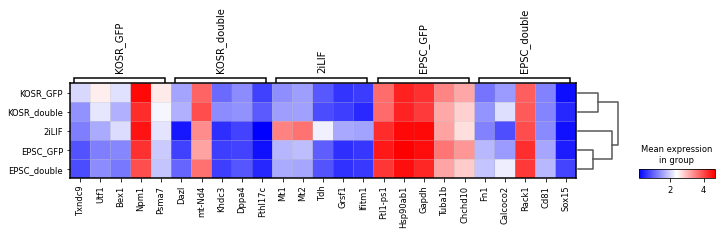

In [34]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, cmap='bwr')

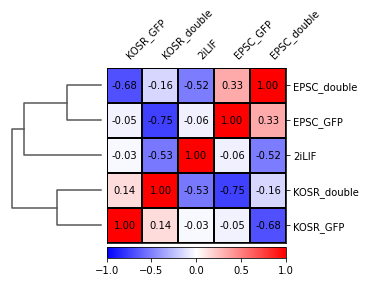

In [35]:
sc.pl.correlation_matrix(adata, 'Stage', figsize=(5,3.5), show_correlation_numbers=True)

In [36]:
adata.write("../data/processed/10_dataset_v2.h5ad")